In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
import gc
from tqdm import tqdm_notebook

/Users/jeong/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
trans_cat_cols = ["ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2","P_emaildomain_bin","P_emaildomain_suffix",
                   "R_emaildomain_bin","R_emaildomain_suffix","M1","M2","M3","M4","M5","M6","M7","M8","M9"]

iden_cat_cols = ["DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32","id_33","id_34","id_35","id_36",
                   "id_37","id_38"]

In [4]:
def transform_transaction_catcols(df1, df2):
    for cat_col in tqdm_notebook( trans_cat_cols): 
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cat_col].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cat_col].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cat_col].dropna() ), set(df2[cat_col].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cat_col].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cat_col].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] = np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] = np.NaN
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect()
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

def transform_identity_catcols(df1,df2):
    for cat_col in tqdm_notebook( iden_cat_cols ): 
        
        # Get the indices for NaN values
        trn_null_ind = [ind for ind, val in enumerate(df1[cat_col].isnull().values) if val == True]
        ts_null_ind = [ind for ind, val in enumerate(df2[cat_col].isnull().values) if val == True]
        
        uniq_train_cat_val , uniq_test_cat_val = set(df1[cat_col].dropna() ), set(df2[cat_col].dropna() )
        common_cat_val = uniq_train_cat_val.intersection(uniq_test_cat_val)
        df1.loc[ ~df1[cat_col].isin( common_cat_val), cat_col ] = -99999
        df2.loc[ ~df2[cat_col].isin( common_cat_val), cat_col ] = -99999
        
        # Replace the value for orignal NaN values
        df1.loc[df1.index.isin(trn_null_ind), cat_col] =  np.NaN
        df2.loc[df2.index.isin(ts_null_ind), cat_col] =  np.NaN
        
        
    del uniq_train_cat_val, uniq_test_cat_val, common_cat_val; gc.collect();
    
    # Reduce the usage of memory
    df1 = reduce_mem_usage(df1)
    df2 = reduce_mem_usage(df2)
    
    return df1, df2

## 1. Preprocessing

In [5]:
train_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_identity.csv")
train_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/train_transaction.csv")

test_idf = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_identity.csv")
test_trans = pd.read_csv("/Users/jeong/downloads/IEEE/input/test_transaction.csv")

### Email Preprocessing 

In [6]:
# email preprocessing 
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

In [7]:
emaildomain = ['P_emaildomain', 'R_emaildomain']
for c in emaildomain:
    train_trans[c + '_bin'] = train_trans[c].map(emails)
    test_trans[c + '_bin'] = test_trans[c].map(emails)
    
    train_trans[c + '_suffix'] = train_trans[c].map(lambda x: str(x).split('.')[-1])
    test_trans[c + '_suffix'] = test_trans[c].map(lambda x: str(x).split('.')[-1])
    
    train_trans[c + '_suffix'] = train_trans[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_trans[c + '_suffix'] = test_trans[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

## 2. Feature Engineering 

### Date

In [8]:
# timeblock으로 시간을 만드는 코드 
import datetime 

start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train_trans['timeblock'] = train_trans['TransactionDT'].apply(lambda x: datetime.timedelta(seconds = x) + start_date ) 
test_trans['timeblock'] = test_trans['TransactionDT'].apply(lambda x: datetime.timedelta(seconds = x) + start_date ) 

tb = train_trans['timeblock']
train_trans.drop('timeblock', 1, inplace=True)
train_trans.insert(0, 'timeblock', tb)

tb = test_trans['timeblock']
test_trans.drop('timeblock', 1, inplace=True)
test_trans.insert(0, 'timeblock', tb)

# "가입일로부터의 시간"(D8)을 통해 "가입일"을 만드는 코드. 
def account_start_date(val):
    if np.isnan(val) :
        return np.NaN
    else:
        days=  int( str(val).split('.')[0])
        return pd.Timedelta( str(days) +' days')
    
for i in ['D1', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D11', 'D12', 'D14']:
    train_trans['account_start_day'] = train_trans[i].apply(account_start_date)
    test_trans['account_start_day'] = test_trans[i].apply(account_start_date)

    # account_make_date 컴퓨터가 인식할 수 있도록 수치형으로 바꿔 줌. 
    train_trans['account_make_date'] = (train_trans['timeblock'] - train_trans['account_start_day']).dt.date
    test_trans['account_make_date'] = (test_trans['timeblock'] - test_trans['account_start_day']).dt.date

    train_trans['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(train_trans['account_make_date']).dt.year) + (100 * pd.to_datetime(train_trans['account_make_date']).dt.month) + (1 * pd.to_datetime(train_trans['account_make_date']).dt.day)
    test_trans['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(test_trans['account_make_date']).dt.year) + (100 * pd.to_datetime(test_trans['account_make_date']).dt.month) + (1 * pd.to_datetime(test_trans['account_make_date']).dt.day)

del train_trans['account_make_date']; del test_trans['account_make_date']
del train_trans['account_start_day']; del test_trans['account_start_day']

In [9]:
train_trans['date'] = pd.to_datetime(train_trans['timeblock']).dt.date
test_trans['date'] = pd.to_datetime(test_trans['timeblock']).dt.date

train_trans['year'] = train_trans['timeblock'].dt.year
train_trans['month'] = train_trans['timeblock'].dt.month
train_trans['day'] = train_trans['timeblock'].dt.day
train_trans['dayofweek'] = train_trans['timeblock'].dt.dayofweek
train_trans['hour'] = train_trans['timeblock'].dt.hour
# train_trans['minute'] = train_trans['timeblock'].dt.minute
# train_trans['second'] = train_trans['timeblock'].dt.second

test_trans['year'] = test_trans['timeblock'].dt.year
test_trans['month'] = test_trans['timeblock'].dt.month
test_trans['day'] = test_trans['timeblock'].dt.day
test_trans['dayofweek'] = test_trans['timeblock'].dt.dayofweek
test_trans['hour'] = test_trans['timeblock'].dt.hour
# test_trans['minute'] = test_trans['timeblock'].dt.minute
# test_trans['second'] = test_trans['timeblock'].dt.second

### 소숫점 

In [10]:
train_trans['TransactionAmt_decimal_count'] = ((train_trans['TransactionAmt'] - train_trans['TransactionAmt'].astype(int))).astype(str).apply(lambda x: len(x.split('.')[1]))
test_trans['TransactionAmt_decimal_count'] = ((test_trans['TransactionAmt'] - test_trans['TransactionAmt'].astype(int))).astype(str).apply(lambda x: len(x.split('.')[1]))

In [11]:
train_trans['TransactionAmt_decimal'] = ((train_trans['TransactionAmt'] - train_trans['TransactionAmt'].astype(int)) * 1000).astype(int)
test_trans['TransactionAmt_decimal'] = ((test_trans['TransactionAmt'] - test_trans['TransactionAmt'].astype(int)) * 1000).astype(int)

### Count Encoding 

In [12]:
categorical_variables_trans = ["ProductCD","card1","card2","card3","card4","card5","card6","addr1","addr2","P_emaildomain","R_emaildomain","P_emaildomain_bin",
                   "R_emaildomain_bin","M1","M2","M3","M4","M5","M6","M7","M8","M9"]

categorical_variables_idf = ["DeviceType","DeviceInfo","id_12",
                   "id_13","id_14","id_15","id_16","id_17","id_18","id_19","id_20","id_21","id_22","id_23","id_24",
                   "id_25","id_26","id_27","id_28","id_29","id_30","id_31","id_32","id_33","id_34","id_35","id_36",
                   "id_37","id_38"]

for i in tqdm_notebook(categorical_variables_trans):
    train_trans['{}_count_full'.format(i)] = train_trans[i].map(pd.concat([train_trans[i], test_trans[i]], ignore_index=True).value_counts(dropna=False))
    test_trans['{}_count_full'.format(i)] = test_trans[i].map(pd.concat([train_trans[i], test_trans[i]], ignore_index=True).value_counts(dropna=False))
    
for i in tqdm_notebook(categorical_variables_idf):
    train_idf['{}_count_full'.format(i)] = train_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False))
    test_idf['{}_count_full'.format(i)] = test_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False))

### Preprocessing 

In [13]:
train_trans, test_trans =  transform_transaction_catcols(train_trans, test_trans)
train_idf, test_idf =  transform_identity_catcols(train_idf, test_idf)


Mem. usage decreased to 652.17 Mb (67.0% reduction)
Mem. usage decreased to 566.82 Mb (66.5% reduction)



Mem. usage decreased to 44.84 Mb (41.8% reduction)
Mem. usage decreased to 44.12 Mb (41.8% reduction)


In [14]:
total_trans = pd.concat([train_trans,test_trans],axis=0,sort=False)
D_columns = [c for c in train_trans.columns if (c[0] == 'D')]
for i in D_columns:
    total_trans_size = total_trans.groupby(['year','month'])[i].agg({'mean'}).reset_index()
    train_trans = train_trans.merge(total_trans_size,how='left',on=['year','month'])
    test_trans = test_trans.merge(total_trans_size,how='left',on=['year','month'])
    
    train_trans[i] = train_trans[i] / train_trans['mean']
    test_trans[i] = test_trans[i] / test_trans['mean']
    del train_trans['mean']; del test_trans['mean']

### 카테고리의 결합 

In [15]:
train_trans['card1_addr1'] = train_trans['card1'].astype(str) + '_' + train_trans['addr1'].astype(str)
test_trans['card1_addr1'] = test_trans['card1'].astype(str) + '_' + test_trans['addr1'].astype(str)

In [16]:
train_trans['card1_addr2'] = train_trans['card1'].astype(str) + '_' + train_trans['addr2'].astype(str)
test_trans['card1_addr2'] = test_trans['card1'].astype(str) + '_' + test_trans['addr2'].astype(str)

In [17]:
train_trans['card1_ProductCD'] = train_trans['card1'].astype(str) + '_' + train_trans['ProductCD'].astype(str)
test_trans['card1_ProductCD'] = test_trans['card1'].astype(str) + '_' + test_trans['ProductCD'].astype(str)

In [18]:
train_trans['TransactionAmt_ProductCD'] = train_trans['TransactionAmt'].astype(str) + '_' + train_trans['ProductCD'].astype(str)
test_trans['TransactionAmt_ProductCD'] = test_trans['TransactionAmt'].astype(str) + '_' + test_trans['ProductCD'].astype(str)

In [19]:
train_trans['addr1_addr2'] = train_trans['addr1'].astype(str) + '_' + train_trans['addr2'].astype(str)
test_trans['addr1_addr2'] = test_trans['addr1'].astype(str) + '_' + test_trans['addr2'].astype(str)

### 결합된 카테고리의 Count Encoding 

In [20]:
categorical_variables_trans = ["card1_addr1", "card1_addr2", "card1_ProductCD",'TransactionAmt_ProductCD','addr1_addr2']

categorical_variables_idf = []

for i in tqdm_notebook(categorical_variables_trans):
    train_trans['{}_count_full'.format(i)] = train_trans[i].map(pd.concat([train_trans[i], test_trans[i]], ignore_index=True).value_counts(dropna=False))
    test_trans['{}_count_full'.format(i)] = test_trans[i].map(pd.concat([train_trans[i], test_trans[i]], ignore_index=True).value_counts(dropna=False))

'''
for i in tqdm_notebook(categorical_variables_idf):
    train_idf['{}_count_full'.format(i)] = train_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False))
    test_idf['{}_count_full'.format(i)] = test_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False)
'''   

"\nfor i in tqdm_notebook(categorical_variables_idf):\n    train_idf['{}_count_full'.format(i)] = train_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False))\n    test_idf['{}_count_full'.format(i)] = test_idf[i].map(pd.concat([train_idf[i], test_idf[i]], ignore_index=True).value_counts(dropna=False)\n"

### 같은 날 같은 card1으로 구매한 동일한 TransactionAmt 

In [21]:
train_trans_Amt = pd.DataFrame(train_trans.groupby(['date','card1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()
test_trans_Amt = pd.DataFrame(test_trans.groupby(['date','card1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()

In [ ]:
train_trans_Amt1 = pd.DataFrame(train_trans.groupby(['date','card3','addr1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()
test_trans_Amt1 = pd.DataFrame(test_trans.groupby(['date','card3','addr1','TransactionAmt'])['TransactionAmt'].agg({'count'})).reset_index()

### 동일한 card의 nunique

### Prev_click , Next_click 

### 결합

In [ ]:
# Data Merge
train_df = pd.merge(train_trans,train_idf,how='left',on='TransactionID')
test_df = pd.merge(test_trans,test_idf,how='left',on='TransactionID')

### Prev_click , Next_click , Prev_Amt , Next_Amt with id info. 

In [ ]:
# ['id_30','id_31','id_33','DeviceType','DeviceInfo']
train_df['id_30_31_33_Type_Info_prev_click'] = train_df['TransactionDT'] - train_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(1)
test_df['id_30_31_33_Type_Info_prev_click'] = test_df['TransactionDT'] - test_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(1)

train_df['id_30_31_33_Type_Info_next_click'] = train_df['TransactionDT'] - train_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(-1)
test_df['id_30_31_33_Type_Info_next_click'] = test_df['TransactionDT'] - test_df.groupby(['id_30','id_31','id_33','DeviceType','DeviceInfo'])['TransactionDT'].shift(-1)

### Merge

In [ ]:
# Data Merge
train_df = pd.merge(train_df,train_trans_Amt,how='left',on=['date','card1','TransactionAmt'])
test_df = pd.merge(test_df,test_trans_Amt,how='left',on=['date','card1','TransactionAmt'])

In [ ]:
# Data Merge
train_df = pd.merge(train_df,train_trans_Amt1,how='left',on=['date','card3','addr1','TransactionAmt'])
test_df = pd.merge(test_df,test_trans_Amt1,how='left',on=['date','card3','addr1','TransactionAmt'])

### kyakovlev 변수 

In [ ]:
# 점수비교 
# https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again

train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card4'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card4'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)
        
########################### Anomaly Search in geo information

# Let's look on bank addres and client addres matching
# card3/card5 bank country and name?
# Addr2 -> Clients geo position (country)
# Most common entries -> normal transactions
# Less common etries -> some anonaly
train_df['bank_type'] = train_df['card3'].astype(str)+'_'+train_df['card5'].astype(str)
test_df['bank_type']  = test_df['card3'].astype(str)+'_'+test_df['card5'].astype(str)

train_df['address_match'] = train_df['bank_type'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['address_match']  = test_df['bank_type'].astype(str)+'_'+test_df['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    temp_df[col] = np.where(temp_df[col].str.contains('nan'), np.nan, temp_df[col])
    temp_df = temp_df.dropna()
    fq_encode = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(fq_encode)
    test_df[col]  = test_df[col].map(fq_encode)

train_df['address_match'] = train_df['address_match']/train_df['bank_type'] 
test_df['address_match']  = test_df['address_match']/test_df['bank_type']

### Aggregate

In [ ]:
i_cols = ['uid','uid2', "card1_addr2", "card1_ProductCD"]

for col in i_cols:
    for agg_type in ['median']:
        new_col_name = col+'_hour_'+agg_type
        temp_df = pd.concat([train_df[[col, 'hour']], test_df[[col,'hour']]])
        temp_df = temp_df.groupby([col])['hour'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

In [ ]:
del train_df['uid']; del train_df['uid2']; del train_df['bank_type']
del test_df['uid']; del test_df['uid2']; del test_df['bank_type']

In [ ]:
total_df = pd.concat([train_df,test_df],axis=0,sort=False)
train_df = train_df.merge(total_df.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), how='left', on = ['card1','account_make_date_D1','ProductCD'])
test_df = test_df.merge(total_df.groupby(['card1','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'card1_D1_productCD_Amt_mean','std':'card1_D1_productCD_Amt_std'}), how='left', on = ['card1','account_make_date_D1','ProductCD'])

In [ ]:
train_df = train_df.merge(total_df.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])
test_df = test_df.merge(total_df.groupby(['card1','card2','card3','card4','addr1','addr2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['card1','card2','card3','card4','addr1','addr2','ProductCD'])

### same_person_card_counts
- 성훈님이 만든 변수로 TransactionAmt, account_make_date와 DeviceInfo가 같은 거래를 같은 사람으로 보는 방법입니다. 

### kmean clustering

In [ ]:
cluster = pd.read_csv("/Users/jeong/downloads/cluster.csv")

train_df = train_df.merge(cluster, on = 'TransactionID', how = 'left')
test_df = test_df.merge(cluster, on = 'TransactionID', how = 'left')
train_df.columns

Index(['timeblock', 'TransactionID', 'isFraud', 'TransactionDT',
       'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       ...
       'address_match', 'uid_hour_median', 'uid2_hour_median',
       'card1_addr2_hour_median', 'card1_ProductCD_hour_median',
       'card1_D1_productCD_Amt_std', 'card1_D1_productCD_Amt_mean',
       'uid2_dayofweek_std', 'uid2_dayofweek_mean', 'Feat7_cluster_label'],
      dtype='object', length=550)

In [ ]:
train_df['Feat7_cluster_label'] = train_df['Feat7_cluster_label'].astype('object')
test_df['Feat7_cluster_label'] = test_df['Feat7_cluster_label'].astype('object')

### Label Encoding 

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in tqdm_notebook(train_df.columns):
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   

## LightGBM - Adversarial Validation 

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [ ]:
features = [c for c in train_df.columns if c not in ['TransactionID', 'isFraud','TransactionDT','timeblock','account_start_day', 'date'
                                                    , 'year', 'month', 'target', 'day','account_make_date_D11', 'account_make_date_D3', 'account_make_date_D5', 'account_make_date_D4' , 'account_make_date_D8', 'account_make_date_D14', 'account_make_date_D6', 'account_make_date_D12', 'account_make_date_D7'
                                                    , 'card_1_2_3_5_nunique', 'card_1_2_3_5_prev_click', 'card_1_2_3_5_next_click', 'card_1_3_TransactionAmt_prev_click', 'card_1_3_TransactionAmt_next_click', 'account_make_date'
                                                    , 'poten_card1_nunique_D5', 'poten_card1_nunique_D11','poten_card1_nunique_D6', 'poten_card1_nunique_D3','poten_card1_nunique_D7','poten_card1_nunique_D12','poten_card1_nunique_D8','poten_card1_nunique_D4','poten_card1_nunique_D14'
                                                    , 'id_13', 'id_31', 'id_13_count_full', 'id_31_count_full','ProductCD', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M7', 'M8', 'M9', 'P_emaildomain_bin',
       'P_emaildomain_suffix', 'R_emaildomain_bin',
       'R_emaildomain_suffix', 'account_make_date',
       'account_make_date_D3', 'account_make_date_D4',
       'account_make_date_D7', 'account_make_date_D8',
       'account_make_date_D11', 'account_make_date_D12',
       'account_make_date_D14', 'dayofweek', 'hour', 'card1_addr1',
       'card1_ProductCD', 'count_x', 'count_y', 'D15', "card1_TransactionAmt_mean",
        'card1_addr1hourstd','card1_addr1hourmedian','uid_hour_std','uid2_hour_std','card1_ProductCD_hour_std','card1_addr2_hour_std',
        'card1_TransactionAmt_nunique','card2_TransactionAmt_nunique','card3_TransactionAmt_nunique','card5_TransactionAmt_nunique','uid_TransactionAmt_nunique',
        'uid_hour_nunique','uid2_hour_nunique','card1_addr2_hour_nunique','card1_ProductCD_hour_nunique','account_make_date_D1','card1_year_month_mean','uid2_D4_mean','uid2_dayofweek_std']]

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train_df.columns.tolist()

In [ ]:
from sklearn import model_selection, preprocessing, metrics

train['target'] = 0
test['target'] = 1

train_test = pd.concat([train, test], axis =0)
target = train_test['target'].values

train, test = model_selection.train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)
train_y = train['target'].values
test_y = test['target'].values
del train['target'], test['target']
gc.collect()

train = lgb.Dataset(train[features], label=train_y)
test = lgb.Dataset(test[features], label=test_y)

In [ ]:
# 문제점
# 파라미터에 따라서 아래와 결과가 달라짐. 
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [ ]:
num_round = 50
clf = lgb.train(params, train, num_round, valid_sets = [train, test], verbose_eval=50, early_stopping_rounds = 50)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [41]:
feature_imp.sort_values(by='Value',ascending=False)

,Value,Feature
495,2112,D3
494,1546,D5
493,1490,D11
492,1412,D1
491,1242,D4
490,1024,D2
489,864,D10
488,606,card1_D1_productCD_Amt_std
487,377,C13
486,369,card1_D1_productCD_Amt_mean


In [42]:
feature_imp.sort_values(by='Value',ascending=False).to_csv("importance.csv",index=False)

## RandomForestClassifier - Covariate Shift

## LightGBM - 8 : 2 Split 

In [43]:
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [44]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [45]:
y = train_df['isFraud']
X = train_df[features].reset_index(drop=True)

test = test_df[features].reset_index(drop=True)

In [46]:
from time import time
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.975303	valid_1's auc: 0.887548
[200]	training's auc: 0.98733	valid_1's auc: 0.894081
[300]	training's auc: 0.994784	valid_1's auc: 0.900207
[400]	training's auc: 0.998266	valid_1's auc: 0.904596
[500]	training's auc: 0.999464	valid_1's auc: 0.907418
[600]	training's auc: 0.999852	valid_1's auc: 0.909348
[700]	training's auc: 0.99996	valid_1's auc: 0.910411
[800]	training's auc: 0.99999	valid_1's auc: 0.91105
[900]	training's auc: 0.999998	valid_1's auc: 0.911521
[1000]	training's auc: 0.999999	valid_1's auc: 0.911866
Early stopping, best iteration is:
[995]	training's auc: 0.999999	valid_1's auc: 0.911872
Fold 1 finished in 0:01:58.830752
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.976544	valid_1's auc: 0.911659
[200]	training's auc: 0.987085	valid_1's auc: 0.918462
[300]	training's auc: 0.99363	valid_1's auc: 0.923782
[

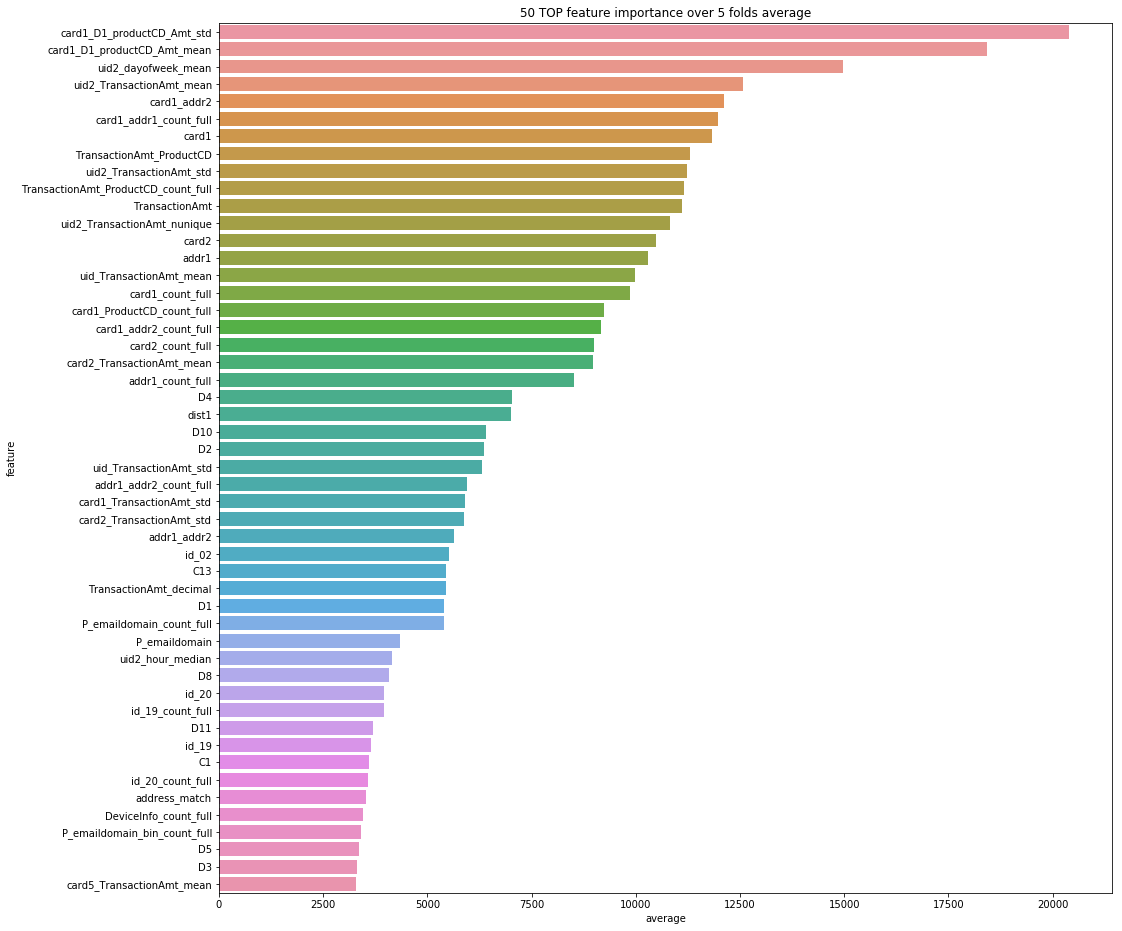

In [47]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [48]:
feature_importances.sort_values(by='average',ascending=False)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
494,card1_D1_productCD_Amt_std,11774,15073,14468,37987,22687,20397.8
493,card1_D1_productCD_Amt_mean,10290,12657,12310,33618,23198,18414.6
495,uid2_dayofweek_mean,9195,11130,11089,26040,17371,14965.0
485,uid2_TransactionAmt_mean,7403,8677,8393,23132,15260,12573.0
401,card1_addr2,7974,9310,8610,20903,13838,12127.0
404,card1_addr1_count_full,7344,9123,8722,22001,12658,11969.6
1,card1,8908,8785,8340,19957,13106,11819.2
402,TransactionAmt_ProductCD,7925,8478,6989,21052,12016,11292.0
486,uid2_TransactionAmt_std,6995,7810,7780,20211,13319,11223.0
407,TransactionAmt_ProductCD_count_full,7378,8282,7109,21105,11926,11160.0


In [49]:
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

C:\Users\User\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        feature_fraction=0.3797454081646243, importance_type='split',
        learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.03454472573214212,
        min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=1314, num_leaves=491,
        objective='binary', random_state=47, reg_alpha=0.3899927210061127,
        reg_lambda=0.6485237330340494, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [50]:
sub = pd.read_csv("./input/sample_submission.csv")
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('BaseLine_IEEE_Model_9500_v9.csv', index=False)